## 统计TM500 Ticket/Pronto数据

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings('ignore')

### TM500 Issue List统计

In [2]:
'''
数据格式说明：
TM500 Issue List每周由TM500发出，包括目前状态为open的ticket和本周closed的ticket的列表。
注意目前状态为open的ticket不是每周新report的ticket!
'''

# TM500 weekly report路径
report_path = r'D:\TM500\Report\2017' 

try: 
    os.chdir(report_path)
except:
    print("The folder does not exist!")
    
# 获取report文件列表
def get_report_list():
    report_list = glob.glob("./*2017_W*.xlsx")
    if report_list is None:
        print("No files existed!")
    return report_list

# 从report文件中分别获取open ticket和close ticket数据并以dataframe格式返回
def get_report_data(file):
    report_data = pd.read_excel(file, sheetname=0)
    report_data.dropna(axis=0, how='all', inplace=True)
    report_data.dropna(axis=1, how='all', inplace=True)
    report_data.reset_index(inplace=True, drop=True)  # 重置索引并重新对索引排序
    index = report_data.index[report_data['Priority']=='Tickets closed in this week'] # 找出open ticket和close ticket的分界线
    ticket_opened_data = report_data.iloc[:index.tolist()[0],:]
    ticket_closed_data = report_data.iloc[index.tolist()[0]+1:,:] 
    
    week = re.search(r'.*(W\d+).*', file).group(1)
    
    return week, ticket_opened_data, ticket_closed_data

# 返回所有report中数据（datafram格式）
def get_report_list_data(report_list):
    ticket_opened_data_list = []
    ticket_closed_data_list = []    
    week_list = []
    
    for report in report_list:
        week, ticket_opened_data, ticket_closed_data = get_report_data(report)
        week_list.append(week)
        ticket_opened_data_list.append(ticket_opened_data)
        ticket_closed_data_list.append(ticket_closed_data)
         
    return week_list, ticket_opened_data_list, ticket_closed_data_list

# 纠正和统一'Action On'行中的一些拼写便于后面的分类操作
def clean_up_data(data):
    data['Action On'] = data['Action On'].apply(lambda x: x.lower())
#     print(data.groupby('Action On').size())
    data['Action On'].replace('license transfer', 'License Issue', inplace=True)
    data['Action On'].replace('license', 'License Issue', inplace=True)
    data['Action On'].replace('licesne', 'License Issue', inplace=True)
    data['Action On'].replace('lincese', 'License Issue', inplace=True)
    data['Action On'].replace('no fault found', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('no fualt found', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('nokia', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('nok', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('enb', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('configuration error', 'Not TM500 Issue', inplace=True)
    data['Action On'].replace('hw', 'HW Issue', inplace=True)
    data['Action On'].replace('hardware', 'HW Issue', inplace=True)
    data['Action On'].replace('sw', 'SW Issue', inplace=True)
    data['Action On'].replace('tm500', 'SW Issue', inplace=True)
    data['Action On'].replace('r&d', 'SW Issue', inplace=True)
    data['Action On'].replace('query', 'Query Issue', inplace=True)
    data['Action On'].replace('upgrade', 'Upgrade', inplace=True)
    data['Action On'].replace('script', 'Script Issue', inplace=True)
#     print(data.groupby('Action On').size())
    return data

# 处理所有数据并且可视化结果
def handle_report_list_data(report_list):    
    ticket_closed_num = []
    ticket_opened_num = []
    ticket_reported_cumsum = []
    ticket_closed_cumsum = []
    
    week_list, ticket_opened_data_list, ticket_closed_data_list = get_report_list_data(report_list)
    ticket_opened_data_all = pd.concat(ticket_opened_data_list)
    ticket_closed_data_all = pd.concat(ticket_closed_data_list)
    ticket_closed_data_all = clean_up_data(ticket_closed_data_all)
        
    report_num = len(week_list)
    for i in range(report_num):
        ticket_closed_num.append(len(ticket_closed_data_list[i]))
        ticket_opened_num.append(len(ticket_opened_data_list[i]))
        # 当前所有reported的ticket的个数ticket_reported_cumsum等于之前所有Close的ticket的数目加上本周状态仍为Open的ticket的个数
        ticket_reported_cumsum.append(len(ticket_opened_data_list[i])+np.cumsum(ticket_closed_num)[i])  
        ticket_closed_cumsum.append(np.cumsum(ticket_closed_num)[i])
    
    print('Total Reported Ticket Number:', ticket_reported_cumsum[report_num-1])
    print('Total Closed Ticket Number:', ticket_closed_cumsum[report_num-1])
    
    # 按星期对ticket统计结果可视化
    fig = plt.figure(1,(22,10))
    ax1 = fig.add_subplot(111)
    # bottom参数用于绘制堆叠柱状图
    ax1.bar(week_list, ticket_closed_num, bottom=ticket_opened_num, color='#BCEE68', label='Closed Ticket Number',)
    ax1.bar(week_list, ticket_opened_num, color='#FF83FA', label='Opened Ticket Number')
    ax1.set_xlim(-1,report_num) # 设置x轴第一个tick到y轴之间距离
    ax1.set_ylim(0, np.max(ticket_closed_num)+np.max(ticket_opened_num)+5)
    ax1.set_xlabel('Week', fontsize=12)
    ax1.set_ylabel('Reported/Closed Ticket Number', fontsize=12)
    ax1.legend(loc=2, fontsize=12)
    ax1.set_title('TM500 Weekly Reported/Closed Ticket Number Stat(2017)', fontsize=15)  
    ax1.yaxis.set_tick_params(labelsize=12) #设置tick label文字大小
    
    ax2 = ax1.twinx()
    ax2.plot(week_list, ticket_closed_cumsum, 'D-', markeredgecolor='g', markerfacecolor='w', lw=2.0, label='Accumulated Closed Ticket Number')
    ax2.plot(week_list, ticket_reported_cumsum, 's-', markeredgecolor='r', markerfacecolor='w', lw=2.0, label='Accumulated Reported Ticket Number')
    ax2.set_ylim(0, ticket_reported_cumsum[report_num-1]+100) #
    ax2.set_ylabel('Accumulated Reported/Closed Ticket Number', fontsize=12)
    ax2.legend(loc=1, fontsize=12)
    ax2.yaxis.set_tick_params(labelsize=12) #设置tick label文字大小
    # 设置tick和tick label之间的距离 
    # ax1.tick_params(direction='out', pad=15)
    plt.show()  
    
    # 对总ticket分类统计可视化
    fig = plt.figure(1,(16,8))
    ax1 = fig.add_subplot(121)
    color1 = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
    label1 = ['Priority-4', 'Priority-3', 'Priority-2', 'Priority-1\n(High Priority)' ]
    labeldistance1 = 1.05
    explode1 = (0, 0, 0, 0.05)
    patches1, texts1, autotexts1 = ax1.pie(ticket_closed_data_all['Priority'].value_counts(), labels=label1, 
                                           colors=color1, explode=explode1, labeldistance=labeldistance1,
                                           autopct='%1.2f%%')
    for t in texts1:
        t.set_size(12)
    for t in autotexts1:
        t.set_size(12)
    # ax1.set_title('TM500 Ticket Priority Distribution', weight='bold', size=12, position=(0.5, 0.96)) 
    # Position是title在这个ax中的位置的比例，比如0.5表示X轴方向正中间位置
    ax1.set_title('TM500 Ticket Priority Distribution', fontsize=15, position=(0.5, 0.96))
    
    ax2 = fig.add_subplot(122)
    color2 = ['#99CC33', '#FF9900', '#FFCC00', '#0099CC', '#FFFF66', '#CCCC33', '#FF6600']
    label2 = ['Not TM500 Issue', 'Query', 'License Issue', 'HW Issue', 'SW Issue', 'Script Issue', 'Upgrade']
    labeldistance2 = 1.05 
    # ax2 = ticket_closed_data_all['Action On'].value_counts().plot(kind='pie', colors=color2, autopct='%1.2f%%') #保留是为了检查label顺序和统计数据顺序是否一致
    patches2, texts2, autotexts2 = ax2.pie(ticket_closed_data_all['Action On'].value_counts(), labels=label2,
                                           colors=color2, labeldistance=labeldistance2,
                                           autopct='%1.2f%%')
    # 调整label文字和百分比文字的大小
    for t in texts2:
        t.set_size(12)
    for t in autotexts2:
        t.set_size(12)    
    ax2.set_title('TM500 Ticket Category Summary', fontsize=15, position=(0.5, 0.96))
    
    fig.tight_layout()
    plt.show()

Total Reported Ticket Number: 485
Total Closed Ticket Number: 478


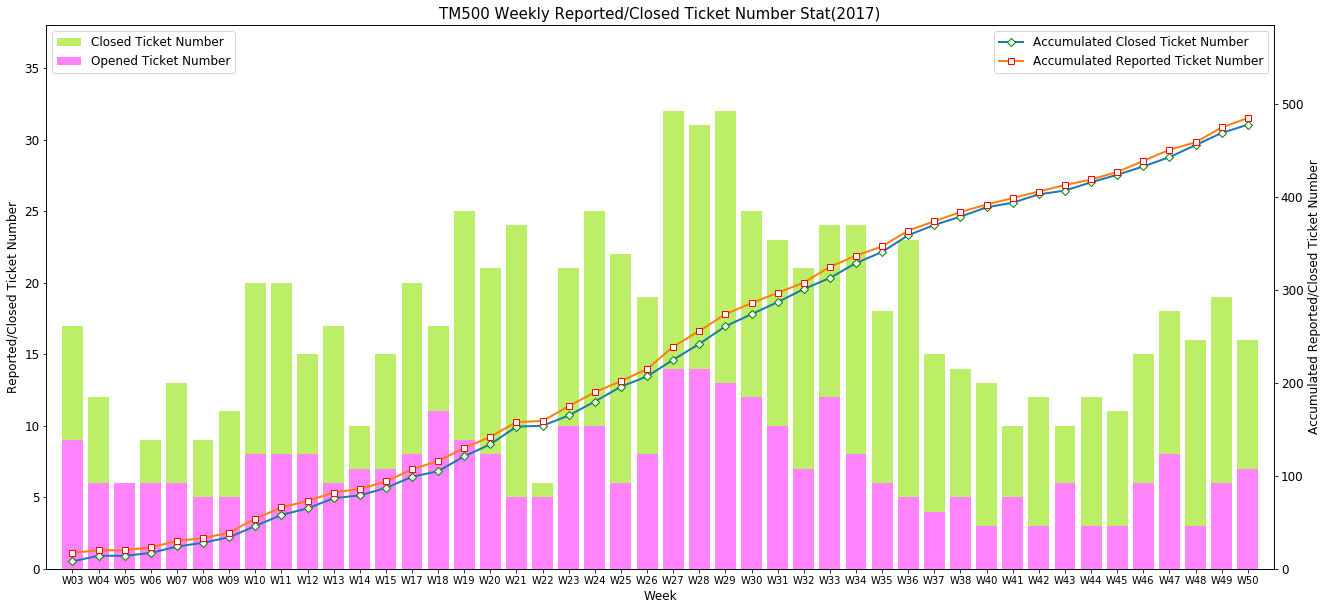

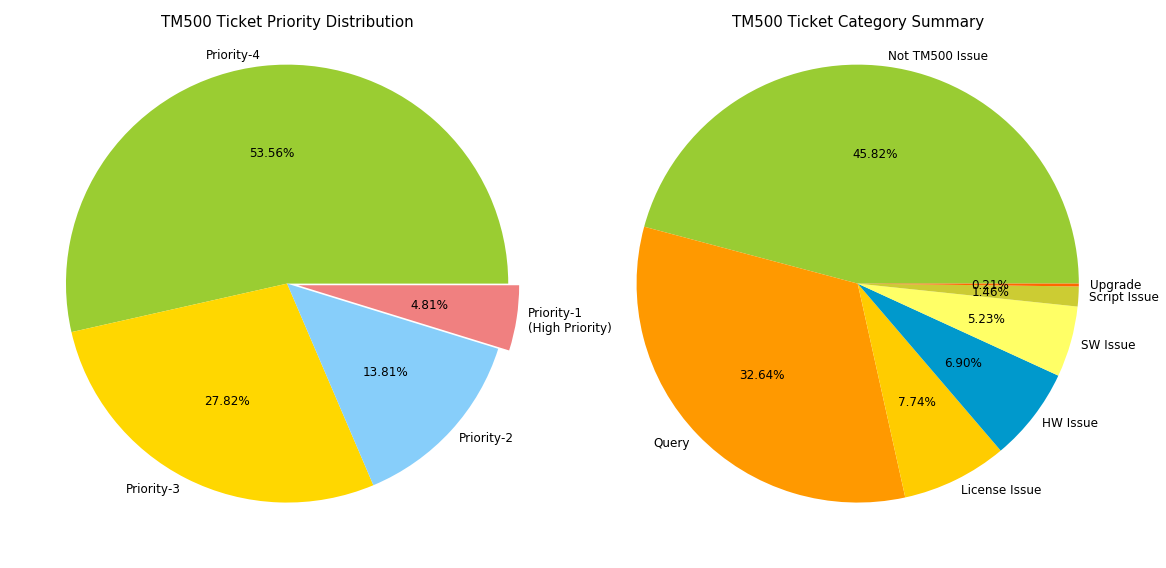

In [3]:
report_list = get_report_list()
handle_report_list_data(report_list)

### TM500 Pronto统计

In [4]:
'''
数据格式说明：
TM500 Pronto List通过PRONTO系统导出，包括指定周期内report的ticket的列表，列表中也包括ticket close的时间。
和TM500 Issue List的格式不同，所以在统计方法上也有些区别
'''

# TM500 pronto文件路径
pronto_path = r'D:\TM500\Pronto'
filename = 'Pronto_Statistics_2017_12_16_12_50_55.csv'

try: 
    os.chdir(pronto_path)
except:
    print("The folder does not exist!")

# 读取文件返回关键字开头行的前一行行号    
def csv_prepare(file, comment='"Problem ID"'):
    nrow = 0
    with open(file, "r", encoding='utf-8') as f:
        for line in f:
            nrow = nrow + 1
            if line.startswith(comment): 
                return nrow-1
            
def load_pronto_data(pronto_file_path=pronto_path, pronto_file_name=filename):
    file = os.path.join(pronto_file_path, pronto_file_name)
    csv_data = pd.read_csv(file, parse_dates=['Reported Date'], 
                           date_parser=lambda dates:[pd.datetime.strptime(d,"%d.%m.%Y") for d in dates],
                           skiprows=csv_prepare(file), na_values=['< empty >'])
    return csv_data   

# 将pronto数据划分为reported ticket和closed ticket两个dataframe，便于后面分别处理
def pronto_data_split(pronto_data):
    # 将CNN和Closed的ticket统一归类为Closed ticket
    pronto_data['State Changed to Closed'] = np.where(pronto_data['State Changed to Closed'].isnull(), 
                                                      pronto_data['State Changed to Correction not needed'],
                                                      pronto_data['State Changed to Closed'])
    # 转换State Changed to Closed列的日期格式
    for index, d in enumerate(pronto_data['State Changed to Closed']):
        if d is not np.nan:
            pronto_data['State Changed to Closed'][index] = pd.datetime.strptime(d,"%d.%m.%Y")  
        
    pronto_reported_data = pronto_data.set_index(['Reported Date'])
    pronto_closed_data = pronto_data.dropna(subset=['State Changed to Closed'], axis=0) # 去掉没有close的ticket
    pronto_closed_data.sort_values('State Changed to Closed', inplace=True)
    pronto_closed_data.set_index(['State Changed to Closed'], inplace=True)
    
    return pronto_reported_data, pronto_closed_data

# 处理所有数据并且可视化结果
def handle_pronto_list_data(pronto_data):  
    pronto_reported_data, pronto_closed_data = pronto_data_split(pronto_data)
    
    # reported ticket和closed ticket的日期范围可能不一致，需要统一处理
    pronto_reported_num = pronto_reported_data.resample('W').size()
    pronto_closed_num = pronto_closed_data.resample('W').size()
    # 统计时间周期为第一个reported的pronto的日期和当前时间日期之间的这一段时间
    date_min = pd.to_datetime(pronto_reported_data.index.min())
    date_max = pd.to_datetime(pd.datetime.now())
    date_index = pd.date_range(date_min, date_max, freq='W')
    # 注意reindex的返回值是series或dataframe
    pronto_reported_num = pronto_reported_num.reindex(date_index, fill_value=0)
    pronto_closed_num = pronto_closed_num.reindex(date_index, fill_value=0)
    
    week_num = len(date_index)
    # %U 一年中的星期数（00-53）星期天为星期的开始
    week_list = ['W' + pd.datetime.date(d).strftime("%U") for d in pronto_reported_num.index]
    pronto_reported_num = pronto_reported_num.tolist()
    pronto_closed_num = pronto_closed_num.tolist()
    # pronto_opened_num_tmp：每周仍然处于open状态的ticket的数目
    # pronto_opened_num_tmp = [np.cumsum(pronto_opened_num)[i]-np.cumsum(pronto_closed_num)[i] for i in range(week_num)]
    
    # pronto_reported_cumsum: 每周所有report的ticket累计数目（包括open和close的）
    # pronto_closed_cumsum: 每周所有close的ticket累计数目
    pronto_reported_cumsum = np.cumsum(pronto_reported_num)
    pronto_closed_cumsum = np.cumsum(pronto_closed_num)
    print('Total Reported Pronto Number:', pronto_reported_cumsum[week_num-1])
    print('Total Closed Ticket Number:', pronto_closed_cumsum[week_num-1])
    
    # 按星期对ticket统计结果可视化
    fig = plt.figure(1,(22,10))
    ax1 = fig.add_subplot(111)
    # bottom参数用于绘制堆叠柱状图
    ax1.bar(week_list, pronto_closed_num, bottom=pronto_reported_num, color='#BCEE68', label='Closed Pronto Number In Week',)
    ax1.bar(week_list, pronto_reported_num, color='#FF83FA', label='Reported Pronto Number')
    ax1.set_xlim(-1, week_num) # 设置x轴第一个tick到y轴之间距离
    ax1.set_ylim(0, np.max(pronto_closed_num)+np.max(pronto_reported_num)+5)
    ax1.set_xlabel('Week', fontsize=12)
    ax1.set_ylabel('Reported/Closed Pronto Number', fontsize=12)
    ax1.legend(loc=2, fontsize=12)
    ax1.set_title('TM500 Weekly Reported/Closed Pronto Number Stat(2017)', fontsize=15)  
    ax1.yaxis.set_tick_params(labelsize=12) #设置tick label文字大小
    ax2 = ax1.twinx()
    ax2.plot(week_list, pronto_closed_cumsum, 'D-', markeredgecolor='g', markerfacecolor='w', lw=2.0, label='Accumulated Closed Pronto Number')
    ax2.plot(week_list, pronto_reported_cumsum, 's-', markeredgecolor='r', markerfacecolor='w', lw=2.0, label='Accumulated Opened Pronto Number')
    ax2.set_ylim(0, pronto_reported_cumsum[week_num-1]+5) #
    ax2.set_ylabel('Accumulated Reported/Closed Pronto Number', fontsize=12)
    ax2.legend(loc=1, fontsize=12)
    ax2.yaxis.set_tick_params(labelsize=12) #设置tick label文字大小
    
    plt.show()    

Total Reported Pronto Number: 29
Total Closed Ticket Number: 25


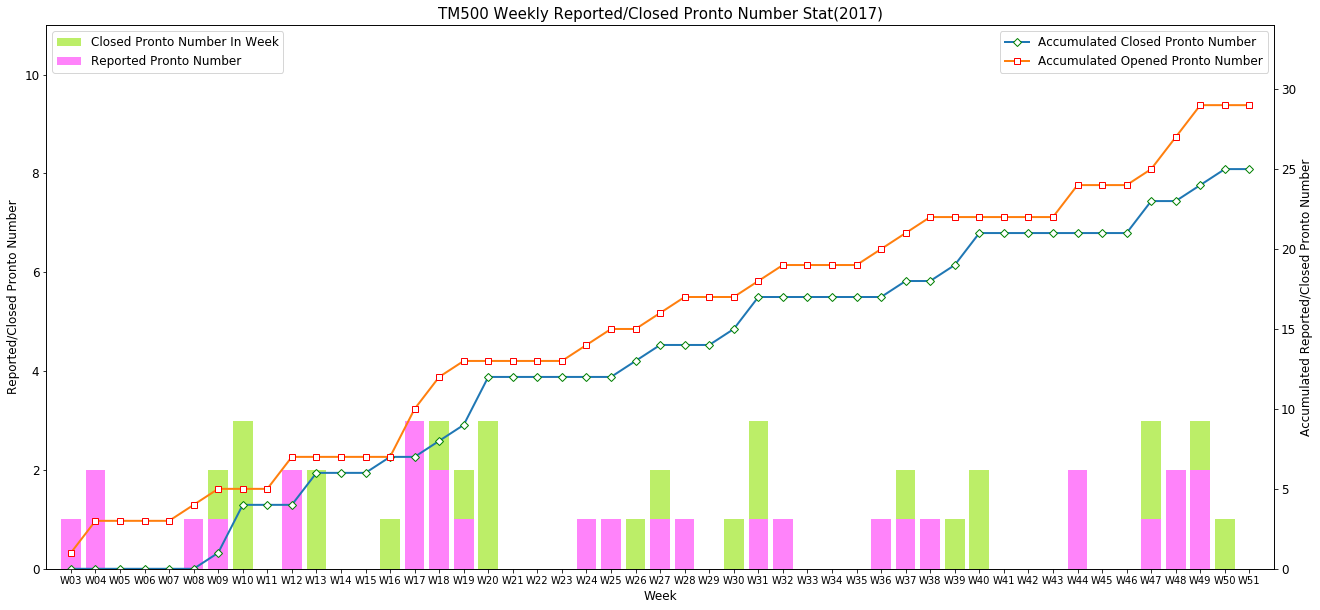

In [5]:
pronto_data = load_pronto_data()
handle_pronto_list_data(pronto_data)